In [1]:
!which python

/home/jose/anaconda3/envs/test/bin/python


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


In [4]:
import pandas as pd

In [124]:
my_data = pd.read_csv('my_data/fake_data.csv')

In [125]:
my_data.head(20)

,t,obj,x,y,z,vx,vy,vz
0,0,1,-1,-1,-1,-1,-1,-1
1,0,2,-2,0,0,0,2,3
2,1,1,-1,1,1,1,1,3
3,1,2,-2,2,2,2,2,3
4,2,1,-1,3,3,3,1,3
5,2,2,-2,4,4,4,2,3
6,3,1,-1,5,5,5,1,3
7,3,2,-3,6,6,6,2,3
8,4,1,-4,-1,-1,-1,-1,-1
9,4,2,-3,0,0,0,2,3


In [126]:
my_data.shape

(16, 8)

In [167]:
from torch.utils.data import Dataset
import os
import numpy as np
import skimage.io as io

ModuleNotFoundError: No module named 'skimage'

In [162]:
class MyCustomDataset(Dataset):
    def __init__(self, csv_file, root_dir: str, transform=None,maxnobjects=2,deep=0,
                nfeatures=6):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.maxnobjects = maxnobjects
        self.deep = deep
        self.nfeatures = nfeatures
        self.obj_id = list()

    def __len__(self):
        return self.data['t'].max()-self.data['t'].min()-self.deep+1 -1

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        #FOr image        
        data = np.zeros((self.maxnobjects,self.nfeatures, self.deep+1))
        #images = np.zeros((self.maxnobjects,1, self.deep))
        

        for t in range(self.deep+1):
            print ("t", t)
            query_data= self.data[self.data['t']== idx+t].iloc[:,1:]
            objects_ids = np.array(query_data.iloc[:,0])
            for oi,o_id in enumerate(objects_ids):
                #print(o_id, "in ", self.obj_id, "time", t)
                ind = self.obj_id.index(o_id) if o_id in self.obj_id else -1
                if ind != -1:
                    #print("updating ", o_id, " index ", ind)
                    data[ind, :,t] = query_data.iloc[oi,1:]
                else:
                    #print ("current ids", self.obj_id, " adding ", o_id)
                    self.obj_id.append(o_id)
                    new_id = len(self.obj_id)-1
                    #print (new_id, " -> NEW ID")
                    data[new_id, :,t] = query_data.iloc[oi,1:]
            #print(objects_ids)#, query_data.iloc[:,2:-1])
            #nobjects, _ = query_data.shape
            #data[:nobjects,:,t] = query_data.iloc[:,1:]
            #images.append(query_data.iloc[:,-1])
            #images[:nobjects,0,t] = query_data.iloc[:,-1]
        #print(data, data.shape)

        image_path = os.path.join(self.root_dir, str(t+1)+".jpg")
        print(image_path)
        image = io.imread(image_path)
        #data = np.array(self.data.iloc[idx, 0:-1]).reshape(-1,8)
        sample = {'image': image, 'data': data}
        
        if self.transform:
            sample = self.transform(sample)
        return sample
        

In [163]:
#FOr testing
#shape maxobject, nfeatures, deep
my_train_dataset = MyCustomDataset("my_data/fake_data.csv", "/my_data/images/train", deep=1)

In [164]:
my_test_dataset = MyCustomDataset("my_data/fake_testdata.csv", "/my_data/images/test", deep=1)

In [165]:
len(my_train_dataset)

6

In [166]:
for i in range(len(my_train_dataset)):
    print("CYCLE", i)
    print (my_train_dataset[i]['data'])

CYCLE 0
t 0
t 1
/my_data/images/train/2.jpg


AttributeError: module 'io' has no attribute 'imread'

In [153]:
batch_size = 4

trainloader = torch.utils.data.DataLoader(my_train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(my_test_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



7
7


In [154]:
len(trainloader), len(testloader)

7
7


(2, 2)

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

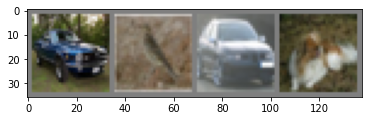

  car  bird   car   dog


In [8]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))


In [9]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [10]:
net = Net().to(device)
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [11]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [12]:
def validate(model,val_data):
    net.eval()
    val_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(val_data, 0):
            # get the inputs; data is a st of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)
            # zero the parameter gradients
            #optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss +=loss.item()
    return val_loss/len(val_data)
        

In [ ]:
net.train()
for epoch in range(20):  # loop over the dataset multiple times
    running_loss = 0.0
    epoch_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a st of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        epoch_loss += loss.item()

        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f'  %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

    val_loss = validate(net, testloader)
    print('[%d, %5d] epoch loss: %.3f validation loss: %.3f'  %
        (epoch + 1, i + 1, epoch_loss / len(trainloader), val_loss))
    epoch_loss = 0.0

print('Finished Training')

/home/jose/anaconda3/envs/test/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /tmp/pip-req-build-4hw0h122/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[1,  2000] loss: 2.187
[1,  4000] loss: 1.856
[1,  6000] loss: 1.684
[1,  8000] loss: 1.575
[1, 10000] loss: 1.522
[1, 12000] loss: 1.465
[1, 12500] epoch loss: 1.702 validation loss: 1.383
[2,  2000] loss: 1.369
[2,  4000] loss: 1.356
[2,  6000] loss: 1.321
[2,  8000] loss: 1.320
[2, 10000] loss: 1.296
[2, 12000] loss: 1.283
[2, 12500] epoch loss: 1.322 validation loss: 1.273
[3,  2000] loss: 1.199
[3,  4000] loss: 1.206
[3,  6000] loss: 1.213
[3,  8000] loss: 1.177
[3, 10000] loss: 1.188
[3, 12000] loss: 1.178
[3, 12500] epoch loss: 1.190 validation loss: 1.140
[4,  2000] loss: 1.095
[4,  4000] loss: 1.114
[4,  6000] loss: 1.087
[4,  8000] loss: 1.072
[4, 10000] loss: 1.133
[4, 12000] loss: 1.090
[4, 12500] epoch loss: 1.099 validation loss: 1.138
[5,  2000] loss: 1.003
[5,  4000] loss: 1.036
[5,  6000] loss: 1.043
[5,  8000] loss: 1.054
[5, 10000] loss: 1.029
[5, 12000] loss: 1.031
[5, 12500] epoch loss: 1.033 validation loss: 1.114
[6,  2000] loss: 0.942
[6,  4000] loss: 0.957
[6, 

In [ ]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

In [ ]:
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))


In [ ]:
net = Net()
net.load_state_dict(torch.load(PATH))


_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))


In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

In [ ]:
# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

In [ ]:
# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))